<a href="https://colab.research.google.com/github/NihaarikaAgarwal/Traffic-Time-Series-Analysis/blob/main/Traffic_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress tracking

## Checking for Stationarity
Trend, cyclic, seasonal, irregularity

In [ ]:
dataset = pd.read_csv("/content/sample_data/train.csv")
# Convert the wide dataset into a DataFrame
df = pd.DataFrame(dataset)
#print(df)

# Melt the DataFrame to convert wide to long format
long_df = pd.melt(df, id_vars=["ids"], var_name="Timestamp", value_name="Traffic")
#print(long_df)

# Convert the Timestamp column to datetime format
long_df["Timestamp"] = pd.to_datetime(long_df["Timestamp"], infer_datetime_format=True)
print(long_df['Timestamp'].head())

<ipython-input-2-743fd1e4179d>:11: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  long_df["Timestamp"] = pd.to_datetime(long_df["Timestamp"], infer_datetime_format=True)


0   2008-01-02 01:00:00
1   2008-01-02 01:00:00
2   2008-01-02 01:00:00
3   2008-01-02 01:00:00
4   2008-01-02 01:00:00
Name: Timestamp, dtype: datetime64[ns]


In [ ]:
print(long_df['Traffic'].head())

0    0.020933
1    0.005917
2    0.013850
3    0.012733
4    0.007850
Name: Traffic, dtype: float64


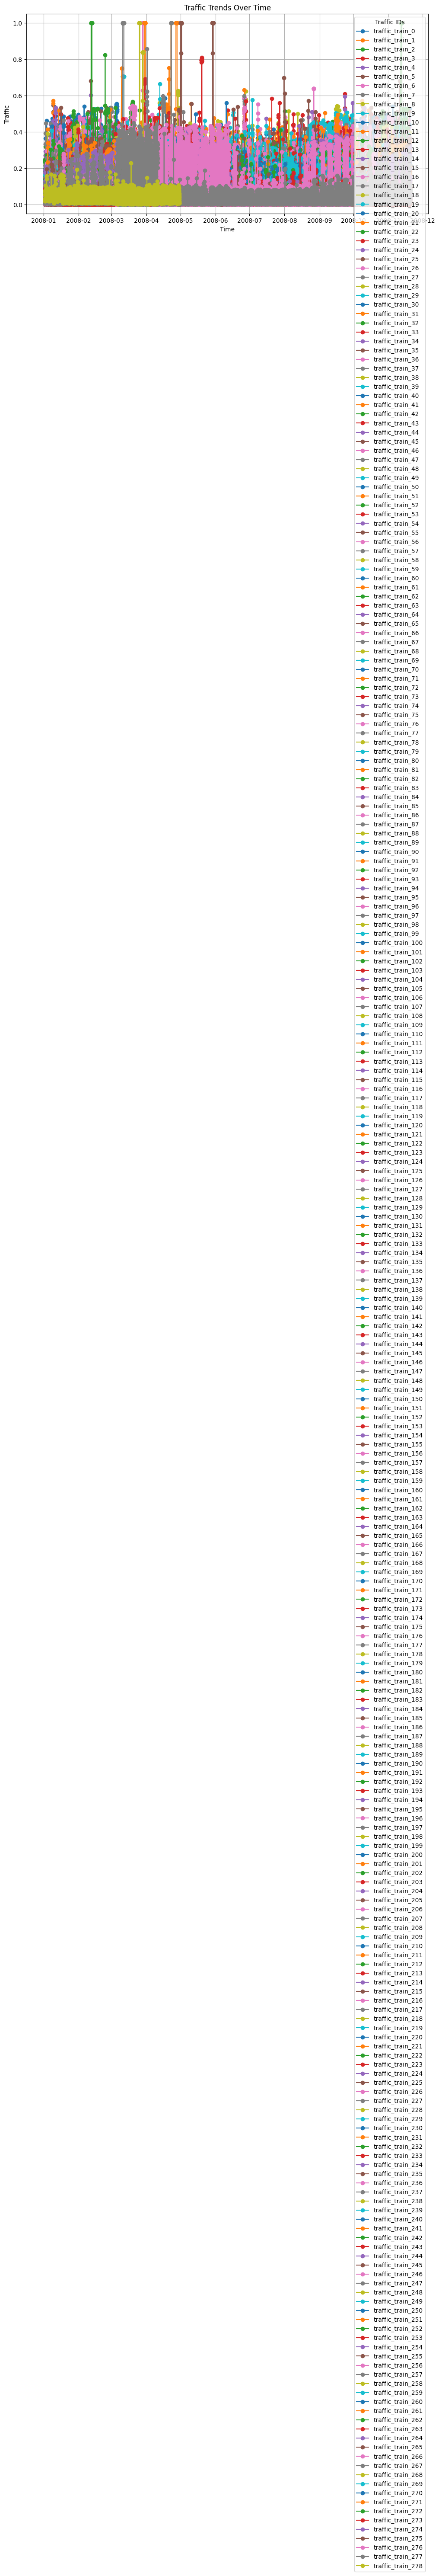

In [ ]:
# Plot the trend
plt.figure(figsize=(12, 6))
for traffic_id in long_df['ids'].unique():
    subset = long_df[long_df['ids'] == traffic_id]
    plt.plot(subset['Timestamp'], subset['Traffic'], marker='o', label=traffic_id)

# Adding labels and title
plt.title('Traffic Trends Over Time')
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.legend(title="Traffic IDs")
plt.grid(True)

# Show the plot
plt.show()


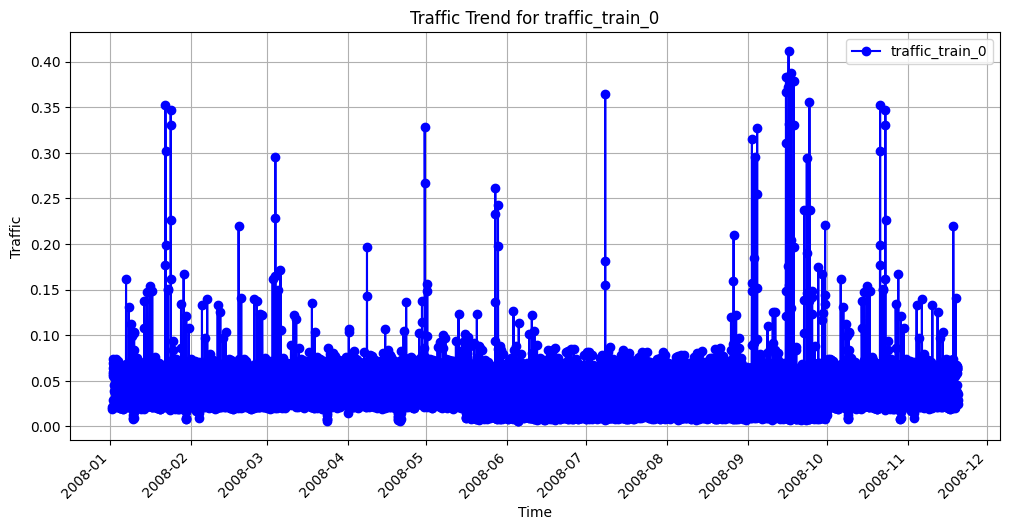

In [ ]:
# Plot the data for 'traffic_train_0'
subset = long_df[long_df['ids'] == 'traffic_train_0']

plt.figure(figsize=(12, 6))
plt.plot(subset['Timestamp'], subset['Traffic'], marker='o', color='blue', label='traffic_train_0')

# Format x-axis to display detailed timestamps
plt.gcf().autofmt_xdate()  # Automatically format x-axis labels
plt.xticks(rotation=45)    # Ensure labels are rotated for better visibility

plt.title('Traffic Trend for traffic_train_0')
plt.xlabel('Time')
plt.ylabel('Traffic')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
print(long_df['Traffic'].dtype)
print(long_df['Traffic'].head())  # Print first few rows
print(long_df['Traffic'].isna().sum())  # Check how many NaN values there are


float64
0    0.020933
1    0.005917
2    0.013850
3    0.012733
4    0.007850
Name: Traffic, dtype: float64
4772


In [ ]:
long_df['Traffic'] = pd.to_numeric(long_df['Traffic'], errors='coerce')  # Ensure 'Traffic' is numeric
long_df['Traffic'] = long_df['Traffic'].fillna(long_df['Traffic'].mean())  # Replace NaN with mean
print(long_df['Traffic'].unique())

[0.02093334 0.00591667 0.01385    ... 0.30445    0.18305002 0.02898334]


In [ ]:
rolmean = long_df['Traffic'].rolling(window=5).mean()
rolstd = long_df['Traffic'].rolling(window=5).std()

In [ ]:
print(rolmean, rolstd)

0               NaN
1               NaN
2               NaN
3               NaN
4          0.012257
             ...   
2109235    0.028097
2109236    0.018200
2109237    0.021860
2109238    0.019640
2109239    0.028163
Name: Traffic, Length: 2109240, dtype: float64 0               NaN
1               NaN
2               NaN
3               NaN
4          0.005867
             ...   
2109235    0.023852
2109236    0.010591
2109237    0.008446
2109238    0.006122
2109239    0.014264
Name: Traffic, Length: 2109240, dtype: float64


<ipython-input-10-3120e2f62392>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_train_0_data['Timestamp'] = pd.to_datetime(traffic_train_0_data['Timestamp'])


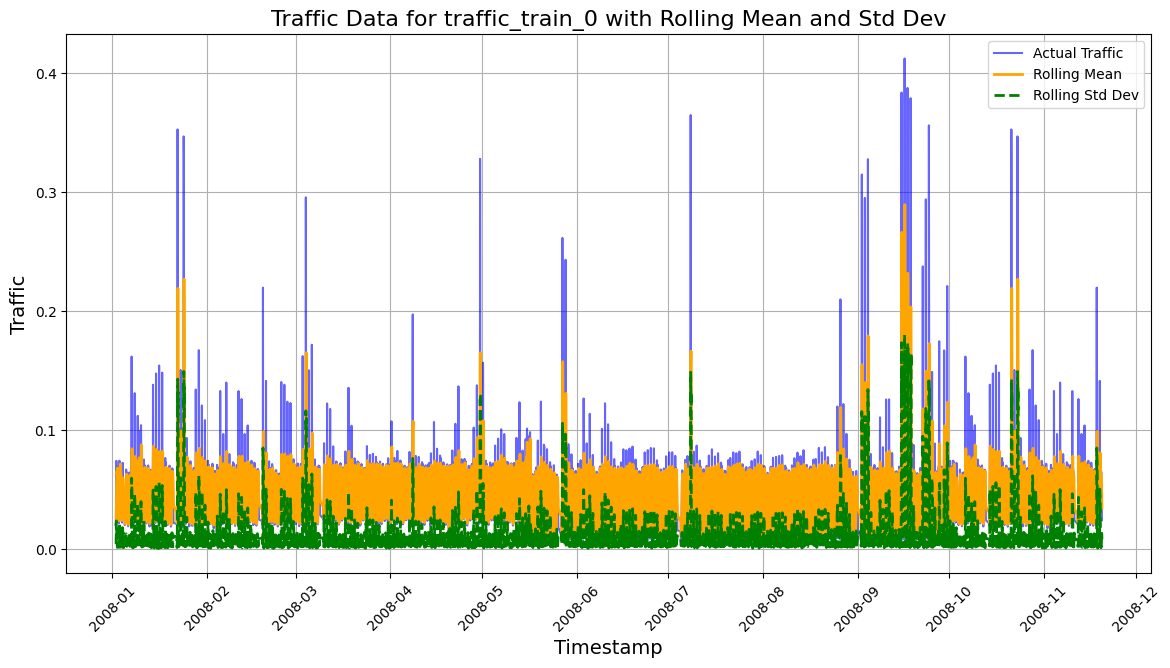

In [ ]:
import matplotlib.pyplot as plt

# Filter data for traffic_train_0
traffic_train_0_data = long_df[long_df['ids'] == 'traffic_train_0']

# Ensure Time is in datetime format
traffic_train_0_data['Timestamp'] = pd.to_datetime(traffic_train_0_data['Timestamp'])

# Sort by Time to avoid plotting issues
traffic_train_0_data = traffic_train_0_data.sort_values(by='Timestamp')

# Calculate rolling mean and standard deviation for traffic_train_0
rolling_mean = traffic_train_0_data['Traffic'].rolling(window=5).mean()
rolling_std = traffic_train_0_data['Traffic'].rolling(window=5).std()

# Plot the data
plt.figure(figsize=(14, 7))

# Plot actual traffic data
plt.plot(traffic_train_0_data['Timestamp'], traffic_train_0_data['Traffic'], label='Actual Traffic', color='blue', alpha=0.6)

# Plot rolling mean
plt.plot(traffic_train_0_data['Timestamp'], rolling_mean, label='Rolling Mean', color='orange', linewidth=2)

# Plot rolling standard deviation
plt.plot(traffic_train_0_data['Timestamp'], rolling_std, label='Rolling Std Dev', color='green', linestyle='--', linewidth=2)

# Add title, labels, legend, and grid
plt.title("Traffic Data for traffic_train_0 with Rolling Mean and Std Dev", fontsize=16)
plt.xlabel("Timestamp", fontsize=14)
plt.ylabel("Traffic", fontsize=14)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller
# Set the ids as index and transpose the DataFrame so that each row is a time series
long_df.set_index('ids', inplace=True)
long_df = df.transpose()

# Now, `df` is a time series where each column represents a series (e.g., traffic_train_0, traffic_train_1, etc.)

# Define a function to perform the Dickey-Fuller test on each time series (column)
def dickey_fuller_test(series):
    result = adfuller(series.dropna())  # Perform ADF test and drop NaN values
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    print('---')

# Perform the Dickey-Fuller test for each time series in the DataFrame
for column in df.columns:
    print(f'\nDickey-Fuller Test for {column}:')
    dickey_fuller_test(df[column])




Dickey-Fuller Test for traffic_train_0:
ADF Statistic: -10.275187919308808
p-value: 3.907411482124238e-18
Critical Values:
	1%: -3.4312183830782534
	5%: -2.86192375982555
	10%: -2.5669742709269356
---

Dickey-Fuller Test for traffic_train_1:
ADF Statistic: -11.649075377185678
p-value: 2.058131761862595e-21
Critical Values:
	1%: -3.4312184984100775
	5%: -2.86192381078607
	10%: -2.5669742980539185
---

Dickey-Fuller Test for traffic_train_2:
ADF Statistic: -10.333022335115666
p-value: 2.8101843188549066e-18
Critical Values:
	1%: -3.4312183830782534
	5%: -2.86192375982555
	10%: -2.5669742709269356
---

Dickey-Fuller Test for traffic_train_3:
ADF Statistic: -12.226799020180342
p-value: 1.0759095336878193e-22
Critical Values:
	1%: -3.4312193065914216
	5%: -2.8619241678890246
	10%: -2.5669744881447225
---

Dickey-Fuller Test for traffic_train_4:
ADF Statistic: -6.378745698762355
p-value: 2.2496187240010013e-08
Critical Values:
	1%: -3.4312193065914216
	5%: -2.8619241678890246
	10%: -2.56697

## Modelling

In [ ]:
class TrajectoryDataset(Dataset):
    def __init__(self, dataframe, window_length=100):
        # Perform the custom transformation
        sliced_df = self.custom_transformation(dataframe.to_numpy(), window_length=window_length)
        self.data = torch.tensor(sliced_df, dtype=torch.float32)

    def __len__(self):
        # Return the number of trajectories
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Get the trajectory at the given index
        return self.data[idx]

    def custom_transformation(self, dataframe_array, window_length):
        num_rows, num_cols = dataframe_array.shape
        window_length += 1  # get one more column as targets

        # Preallocate memory for the slices
        sliced_data = np.lib.stride_tricks.sliding_window_view(dataframe_array, window_shape=(window_length,), axis=1)

        # Reshape into a flat 2D array for DataFrame-like output
        sliced_data = sliced_data.reshape(-1, window_length)

        return sliced_data


Use neural networks because
1. Ability to handle non-linear relationships
2. Feature Extraction and Representation
Neural networks can automatically learn useful features from raw time series data, reducing the need for extensive manual preprocessing or feature engineering.
3. Handling High-Dimensional and Multivariate Data
Many real-world time series datasets are multivariate (e.g., traffic, weather, stock prices). Neural networks can process multiple time series in parallel and learn interdependencies between variables.
They can handle complex scenarios where traditional models may require separate preprocessing for each variable.
8. No Stationarity Assumption
Traditional models often require data to be stationary (constant mean and variance over time). While pre-processing (e.g., differencing) can help, it may lose information.
Neural networks do not inherently require the data to be stationary, as they can learn trends, seasonality, and other temporal patterns directly.

Why are MLPs used:
Handles Nonlinear Relationships: MLPs can capture nonlinear dependencies in the time series that traditional models like ARIMA might struggle with.
Flexible Architecture: You can add more hidden layers or neurons to capture complex patterns, seasonalities, or irregularities.
Multi-Variable Time Series: Can easily integrate multiple input variables (e.g., temperature, humidity, stock prices) to predict one or more outputs.


We use the Sliding Window Approach: Divide the time series into overlapping windows of size
Input: Sequence of past values.
Output: Predict the next value(s).


In [ ]:
# Implement your model
class MLP(nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
         super(MLP, self).__init__()
         self.fc1 = nn.Linear(input_size, hidden_size)
         self.fc2 = nn.Linear(hidden_size, hidden_size)
         self.relu = nn.ReLU()
         # self.sigmoid = nn.Sigmoid()
         self.fc3 = nn.Linear(hidden_size, output_size)

     def forward(self, x):
         out = nn.functional.normalize(x)
         out = self.fc1(out)
         out = self.fc2(out)
         out = self.fc2(out)
         out = self.fc2(out)
         out = self.relu(out)
         # out = self.sigmoid(out)
         out = self.fc3(out)
         return out

In [ ]:
# Implement your model
class MLP_WithSigmoid(nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
         super(MLP, self).__init__()
         self.fc1 = nn.Linear(input_size, hidden_size)
         self.fc2 = nn.Linear(hidden_size, hidden_size)
         self.relu = nn.ReLU()
         self.sigmoid = nn.Sigmoid()
         self.fc3 = nn.Linear(hidden_size, output_size)

     def forward(self, x):
         out = nn.functional.normalize(x)
         out = self.fc1(out)
         out = self.fc2(out)
         out = self.fc2(out)
         out = self.fc2(out)
         out = self.relu(out)
         out = self.sigmoid(out)
         out = self.fc3(out)
         return out

RNNs can handle sequential data, maintain memory, learn long term dependencies and maintain varying sequence lengths. It can capture temporal dependencies also.

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(
            input_size=1,  # Matches the last dimension of the input
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Add an extra dimension if input is 2D
        if x.dim() == 2:
            x = x.unsqueeze(-1)  # Shape: (batch_size, sequence_length, 1)
        gru_out, _ = self.gru(x)
        last_hidden = gru_out[:, -1, :]  # Get the last time step's output
        last_hidden = self.dropout(last_hidden)
        out = self.fc(last_hidden)
        return out

In [ ]:
class GRUModelWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(GRUModelWithDropout, self).__init__()
        input_size = 1
        output_size = 1
        # GRU with dropout applied between layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)

        # Dropout layer after GRU output
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(-1)
        # Pass through GRU
        gru_out, _ = self.gru(x)  # Shape: (batch_size, sequence_length, hidden_size)

        # Get the last hidden state (output from the last time step)
        last_hidden = gru_out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Apply dropout after GRU output
        last_hidden = self.dropout(last_hidden)

        # Fully connected layer to produce the final output
        out = self.fc(last_hidden)  # Shape: (batch_size, output_size)
        return out

## Training loop

In [ ]:
import os

# Get the relative path of a file in the current working directory
train_path = os.path.join('/content/sample_data/train.csv')
val_path = os.path.join('/content/sample_data/val.csv')
test_path = os.path.join('/content/sample_data/test.csv')

train_df = pd.read_csv(train_path, header = 0).drop('ids', axis=1)
val_df = pd.read_csv(val_path, header = 0).drop('ids', axis=1)
test_df = pd.read_csv(test_path, header = 0).drop('ids', axis=1)


In [ ]:
# Check if MPS is available and set the device accordingly
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device("cuda")

window_length = 100  # Example window length
dataset = TrajectoryDataset(dataframe=train_df, window_length=window_length)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model hyperparameters
input_size = window_length  # Window length minus 1 (since the last column is the target)
hidden_size = 64
output_size = 1  # Single output for time series forecast (next value)
learning_rate = 0.0001
num_epochs = 3
dropout=0.3
num_layers=3

# Instantiate the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size).to(device)
# model = GRUModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
# model = GRUModelWithDropout(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with tqdm for progress tracking
for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0
    # Use tqdm to track batch progress within each epoch
    for batch_idx, data in tqdm(enumerate(dataloader), desc=f"Epoch {epoch + 1}", unit="batch", leave=False):
        # Separate inputs and target
        inputs = data[:, :-1].to(device)  # All except last column
        # print(inputs.shape)
        targets = data[:, -1].to(device)  # Last column is the target (next value)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimize
        loss.backward()

        # if batch_idx % 10000 == 0:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] *= 0.9

        optimizer.step()

        running_loss += loss.item()

    # optimizer.param_groups[0]['lr'] *= 0.1

    # Print the average loss per epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}')

Streaming output truncated to the last 5000 lines.
Epoch 1: 45741batch [02:12, 255.01batch/s]
Epoch 1: 45768batch [02:12, 240.54batch/s]
Epoch 1: 45793batch [02:12, 233.69batch/s]
Epoch 1: 45817batch [02:12, 235.04batch/s]
Epoch 1: 45841batch [02:12, 231.86batch/s]
Epoch 1: 45865batch [02:12, 234.03batch/s]
Epoch 1: 45889batch [02:12, 226.07batch/s]
Epoch 1: 45915batch [02:12, 235.52batch/s]
Epoch 1: 45939batch [02:13, 235.02batch/s]
Epoch 1: 45963batch [02:13, 225.38batch/s]
Epoch 1: 45986batch [02:13, 211.93batch/s]
Epoch 1: 46022batch [02:13, 252.33batch/s]
Epoch 1: 46067batch [02:13, 307.36batch/s]
Epoch 1: 46111batch [02:13, 344.00batch/s]
Epoch 1: 46153batch [02:13, 365.54batch/s]
Epoch 1: 46197batch [02:13, 386.28batch/s]
Epoch 1: 46237batch [02:13, 388.49batch/s]
Epoch 1: 46284batch [02:13, 411.91batch/s]
Epoch 1: 46326batch [02:14, 405.70batch/s]
Epoch 1: 46367batch [02:14, 372.59batch/s]
Epoch 1: 46405batch [02:14, 362.06batch/s]
Epoch 1: 46449batch [02:14, 383.07batch/s]
Epo

Epoch [1/3], Loss: 0.0008



Epoch 2: 0batch [00:00, ?batch/s]
Epoch 2: 1batch [00:01,  1.24s/batch]
Epoch 2: 47batch [00:01, 48.09batch/s]
Epoch 2: 82batch [00:01, 86.73batch/s]
Epoch 2: 124batch [00:01, 138.20batch/s]
Epoch 2: 171batch [00:01, 197.93batch/s]
Epoch 2: 211batch [00:01, 237.78batch/s]
Epoch 2: 256batch [00:01, 285.04batch/s]
Epoch 2: 297batch [00:01, 311.43batch/s]
Epoch 2: 342batch [00:02, 346.61batch/s]
Epoch 2: 384batch [00:02, 345.21batch/s]
Epoch 2: 432batch [00:02, 379.25batch/s]
Epoch 2: 474batch [00:02, 374.10batch/s]
Epoch 2: 515batch [00:02, 327.72batch/s]
Epoch 2: 551batch [00:02, 331.09batch/s]
Epoch 2: 587batch [00:02, 327.13batch/s]
Epoch 2: 624batch [00:02, 336.98batch/s]
Epoch 2: 659batch [00:02, 339.16batch/s]
Epoch 2: 703batch [00:03, 365.51batch/s]
Epoch 2: 745batch [00:03, 380.34batch/s]
Epoch 2: 789batch [00:03, 395.40batch/s]
Epoch 2: 829batch [00:03, 358.28batch/s]
Epoch 2: 866batch [00:03, 338.40batch/s]
Epoch 2: 914batch [00:03, 375.66batch/s]
Epoch 2: 960batch [00:03, 397

## Evaluation Loop

In [ ]:
from torch.nn import MSELoss


train_set = torch.tensor(train_df.values[:,:].astype(np.float32), dtype=torch.float32)
val_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)
test_set = torch.tensor(val_df.values[:,:].astype(np.float32), dtype=torch.float32)

points_to_predict = val_set.shape[1]

# Autoregressive prediction function
def autoregressive_predict(model, input_maxtrix, prediction_length=points_to_predict):
    """
    Perform autoregressive prediction using the learned model.

    Args:
    - model: The trained PyTorch model.
    - input_maxtrix: A matrix of initial time steps (e.g., shape (963, window_length)).
    - prediction_length: The length of the future trajectory to predict.

    Returns:
    - output_matrix: A tensor of the predicted future trajectory of the same length as `prediction_length`.
    """
    model.eval()  # Set model to evaluation mode
    output_matrix = torch.empty(input_maxtrix.shape[0],0)
    current_input = input_maxtrix

    with torch.no_grad():  # No need to calculate gradients for prediction
        for idx in range(prediction_length):
            # Predict the next time step
            next_pred = model(current_input)

            # Concatenating the new column along dimension 1 (columns)
            output_matrix = torch.cat((output_matrix, next_pred), dim=1)

            # Use the predicted value as part of the next input
            current_input = torch.cat((current_input[:, 1:],next_pred),dim=1)

    return output_matrix


initial_input = train_set[:, -window_length:]  #use the last window of training set as initial input
full_trajectories = autoregressive_predict(model, initial_input)


# Calculate MSE between predicted trajectories and actual validation trajectories using torch
mse_loss = MSELoss()

# Compute MSE
mse = mse_loss(full_trajectories, val_set)

# Print MSE
print(f'Autoregressive Validation MSE (using torch): {mse.item():.4f}')

Autoregressive Validation MSE (using torch): 0.0630


## Plot


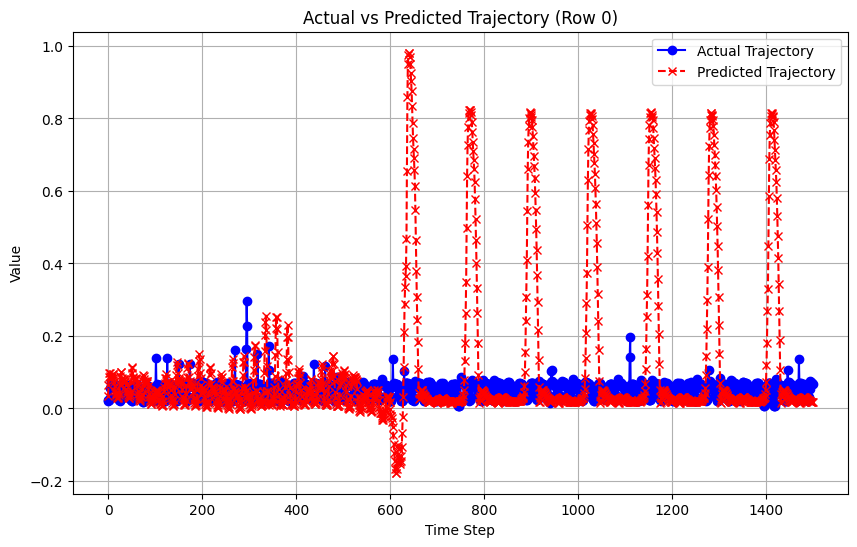

In [ ]:
# Perform autoregressive predictions for one row in the validation set
# We can pick a specific row (e.g., row 0) to visualize
row_idx = 0  # You can change this to visualize predictions for different rows
initial_input = val_set[row_idx, :window_length].unsqueeze(0)

# Predict future trajectory of length 100
predicted_trajectory = autoregressive_predict(model, initial_input)

# Get the actual trajectory for comparison
actual_trajectory = val_set[row_idx].numpy()

# Plot the actual vs predicted trajectory
plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_trajectory)), actual_trajectory, label="Actual Trajectory", color='blue', marker='o')
plt.plot(range(len(actual_trajectory)), predicted_trajectory.squeeze().numpy(), label="Predicted Trajectory", color='red', linestyle='--', marker='x')
plt.title(f"Actual vs Predicted Trajectory (Row {row_idx})")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Generate predictions for all the validation dataset
initial_input = train_set[:, -window_length:]
val_predictions_tensor = autoregressive_predict(model, initial_input)

# Generate predictions for all the test dataset
initial_input = val_predictions_tensor[:, -window_length:]
test_predictions_tensor = autoregressive_predict(model, initial_input)


# Print their shapes
print(f'Validation Predictions Tensor Shape: {val_predictions_tensor.shape}')
print(f'Test Predictions Tensor Shape: {test_predictions_tensor.shape}')


Validation Predictions Tensor Shape: torch.Size([963, 1500])
Test Predictions Tensor Shape: torch.Size([963, 1500])


In [ ]:
def generate_submissions_v4(pred_val_tensor, pred_test_tensor, original_val_path, original_test_path):
    # Read the original validation and testing datasets
    original_val_df = pd.read_csv(original_val_path)
    original_test_df = pd.read_csv(original_test_path)

    # Ensure the shape of pred_val_tensor and pred_test_tensor is correct
    assert pred_val_tensor.shape[0] * pred_val_tensor.shape[1] == original_val_df.shape[0] * (original_val_df.shape[1] - 1)
    assert pred_test_tensor.shape[0] * pred_test_tensor.shape[1] == original_test_df.shape[0] * (original_test_df.shape[1] - 1)

    # Create empty lists to store ids and values
    ids = []
    values = []

    # Process validation set
    for col_idx, col in enumerate(original_val_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_val_df[col]):
            ids.append(str(f"{col}_traffic_val_{row_idx}"))
            values.append(float(pred_val_tensor[row_idx, col_idx]))

    # Process testing set
    for col_idx, col in enumerate(original_test_df.columns[1:]):  # Skip the 'ids' column
        for row_idx, _ in enumerate(original_test_df[col]):
            ids.append(str(f"{col}_traffic_test_{row_idx}"))
            values.append(float(pred_test_tensor[row_idx, col_idx]))

    # Create the submissions dataframe
    submissions_df = pd.DataFrame({
        "ids": ids,
        "value": values
    })

    # Impute any null values
    submissions_df.fillna(100, inplace=True)

    # Assert the shape of the dataframe
    assert submissions_df.shape[1] == 2
    assert submissions_df.shape[0] == (original_val_df.shape[0] * (original_val_df.shape[1] - 1)) + (original_test_df.shape[0] * (original_test_df.shape[1] - 1))
    assert "ids" in submissions_df.columns
    assert "value" in submissions_df.columns

    # Save to CSV
    submissions_df.to_csv('submissions_v3.csv', index=False)

# Call the function
generate_submissions_v4(val_predictions_tensor, test_predictions_tensor, '', '')